# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.8 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 14.1 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-yhtj93d_
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-yhtj93d_
  Resolved https://github.com/huggingface/accelerate to commit bc234c040c3703f00fca0a5b8342dd15c86e7542
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.21.0.dev0-py3-none-any.whl size=235144 sha256=606eca7b2c0ff692418e6a60a1a8e6f16ee2d134ab6ed7393d16812a1928aa29
  Stored in directory: /tmp/pip-ephem-wheel-cache-3_1kct0s/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.20.3
    Uninstalling accelerate-0.20.3:
      Successfully uninstalled accelerate-0.20.3


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
df_p = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/thesis_project_files/main_label/all_R.csv")

In [9]:
df_p = df_p.drop(['Duration', 'comment', 'Role','combine'], axis=1)
df_r = df_r.drop(['Duration', 'comment', 'Role','combine'], axis=1)

In [10]:
df_r = df_r.rename(columns={"Label":"label", "clean_text":"text"})
df_p = df_p.rename(columns={"Label":"label", "clean_text":"text"})

In [11]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [12]:
def exclude(df, labels):
  exclude_idx=[]
  for d in range(0, len(df['label'])):
      if  df['label'][d] not in labels:
          exclude_idx.append(d)
  return df.drop(index=(exclude_idx))


df_r=exclude(df_r, R_labels)
df_p=exclude(df_p, P_labels)

In [13]:
#P_labels=['information','design action', 'failure action','failure reasoning', 'perception']

def convert_p(label):
  label=str(label)
  if label=='information':
      return 0
  elif label=='design action':
      return 1
  elif label=='failure action':
      return 2
  elif label=='failure reasoning':
      return 3
  else:
      return 4

df_p['index']=df_p['label'].apply(convert_p)

In [14]:
#R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

def convert(label):
  label=str(label)
  if label=='introduction':
      return 0
  elif label=='clarification':
      return 1
  elif label=='workshop management':
      return 2
  elif label=='implementation':
      return 3
  else:
      return 4

df_r['index']=df_r['label'].apply(convert)

# Model

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [16]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [18]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [19]:
import torch
torch.cuda.empty_cache()

In [20]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [21]:
intro_len=len(list(df_r.query('label=="introduction"').index))
cl_len=len(list(df_r.query('label=="clarification"').index))
work_len=len(list(df_r.query('label=="workshop management"').index))
imp_len=len(list(df_r.query('label=="implementation"').index))
fail_len=len(list(df_r.query('label=="failure"').index))

In [22]:
# R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']
import random
# Return a list of indices
intro_idx=random.sample(list(df_r.query('label=="introduction"').index), 10)
cl_idx=random.sample(list(df_r.query('label=="clarification"').index),10)
work_idx=random.sample(list(df_r.query('label=="workshop management"').index),10)
imp_idx=random.sample(list(df_r.query('label=="implementation"').index),10)
fail_idx=random.sample(list(df_r.query('label=="failure"').index),10)

# Use indices to select data
train_r = df_r.loc[intro_idx + cl_idx + work_idx+ imp_idx + fail_idx]
index_list=intro_idx + cl_idx + work_idx+ imp_idx + fail_idx

In [23]:
test_r=df_r.drop(index=(index_list))
valid_r, test_r = train_test_split(test_r, test_size=0.8)

In [24]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
# define parameters
EPOCHS = 20

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cdn-lfs.huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [27]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.7566070854663849 accuracy 0.14


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.6471975105149406 accuracy 1.2

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.667881339788437 accuracy 0.22


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.6578216126986913 accuracy 1.92

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.6076801717281342 accuracy 0.28


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.655805332320077 accuracy 0.72

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4107142984867096 accuracy 0.32


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.6466407903603144 accuracy 0.78

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.3002185821533203 accuracy 0.38


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.6280710356576102 accuracy 0.8200000000000001

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.1519842743873596 accuracy 0.54


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.5403068959712982 accuracy 2.48

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.011596605181694 accuracy 0.8


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.4354957725320543 accuracy 3.68

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.7404444739222527 accuracy 0.84


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.4348239515508925 accuracy 3.84

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.4959825426340103 accuracy 0.96


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.3739956212895257 accuracy 3.92

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.45620296895504 accuracy 0.96


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.3403674917561668 accuracy 4.32

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.29886775836348534 accuracy 0.98


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.3691861139876502 accuracy 4.38

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.14082907512784004 accuracy 0.98


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.4022144547530584 accuracy 4.28

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.09611364919692278 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.5532000831195287 accuracy 4.0

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.06336331367492676 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.5975352504423685 accuracy 4.2

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.04341536294668913 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.6510751588003976 accuracy 4.12

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.034980530850589275 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.736771868807929 accuracy 4.0200000000000005

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.027046789415180683 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.786737478205136 accuracy 3.96

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.021130117820575833 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.8233513001884734 accuracy 3.92

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.01952967490069568 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.8318386652639933 accuracy 3.94

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.019231565995141864 accuracy 1.0


  0%|          | 0/28 [00:00<?, ?it/s]

Val loss 1.8341075841869627 accuracy 3.94



In [28]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [29]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.3929629256985672

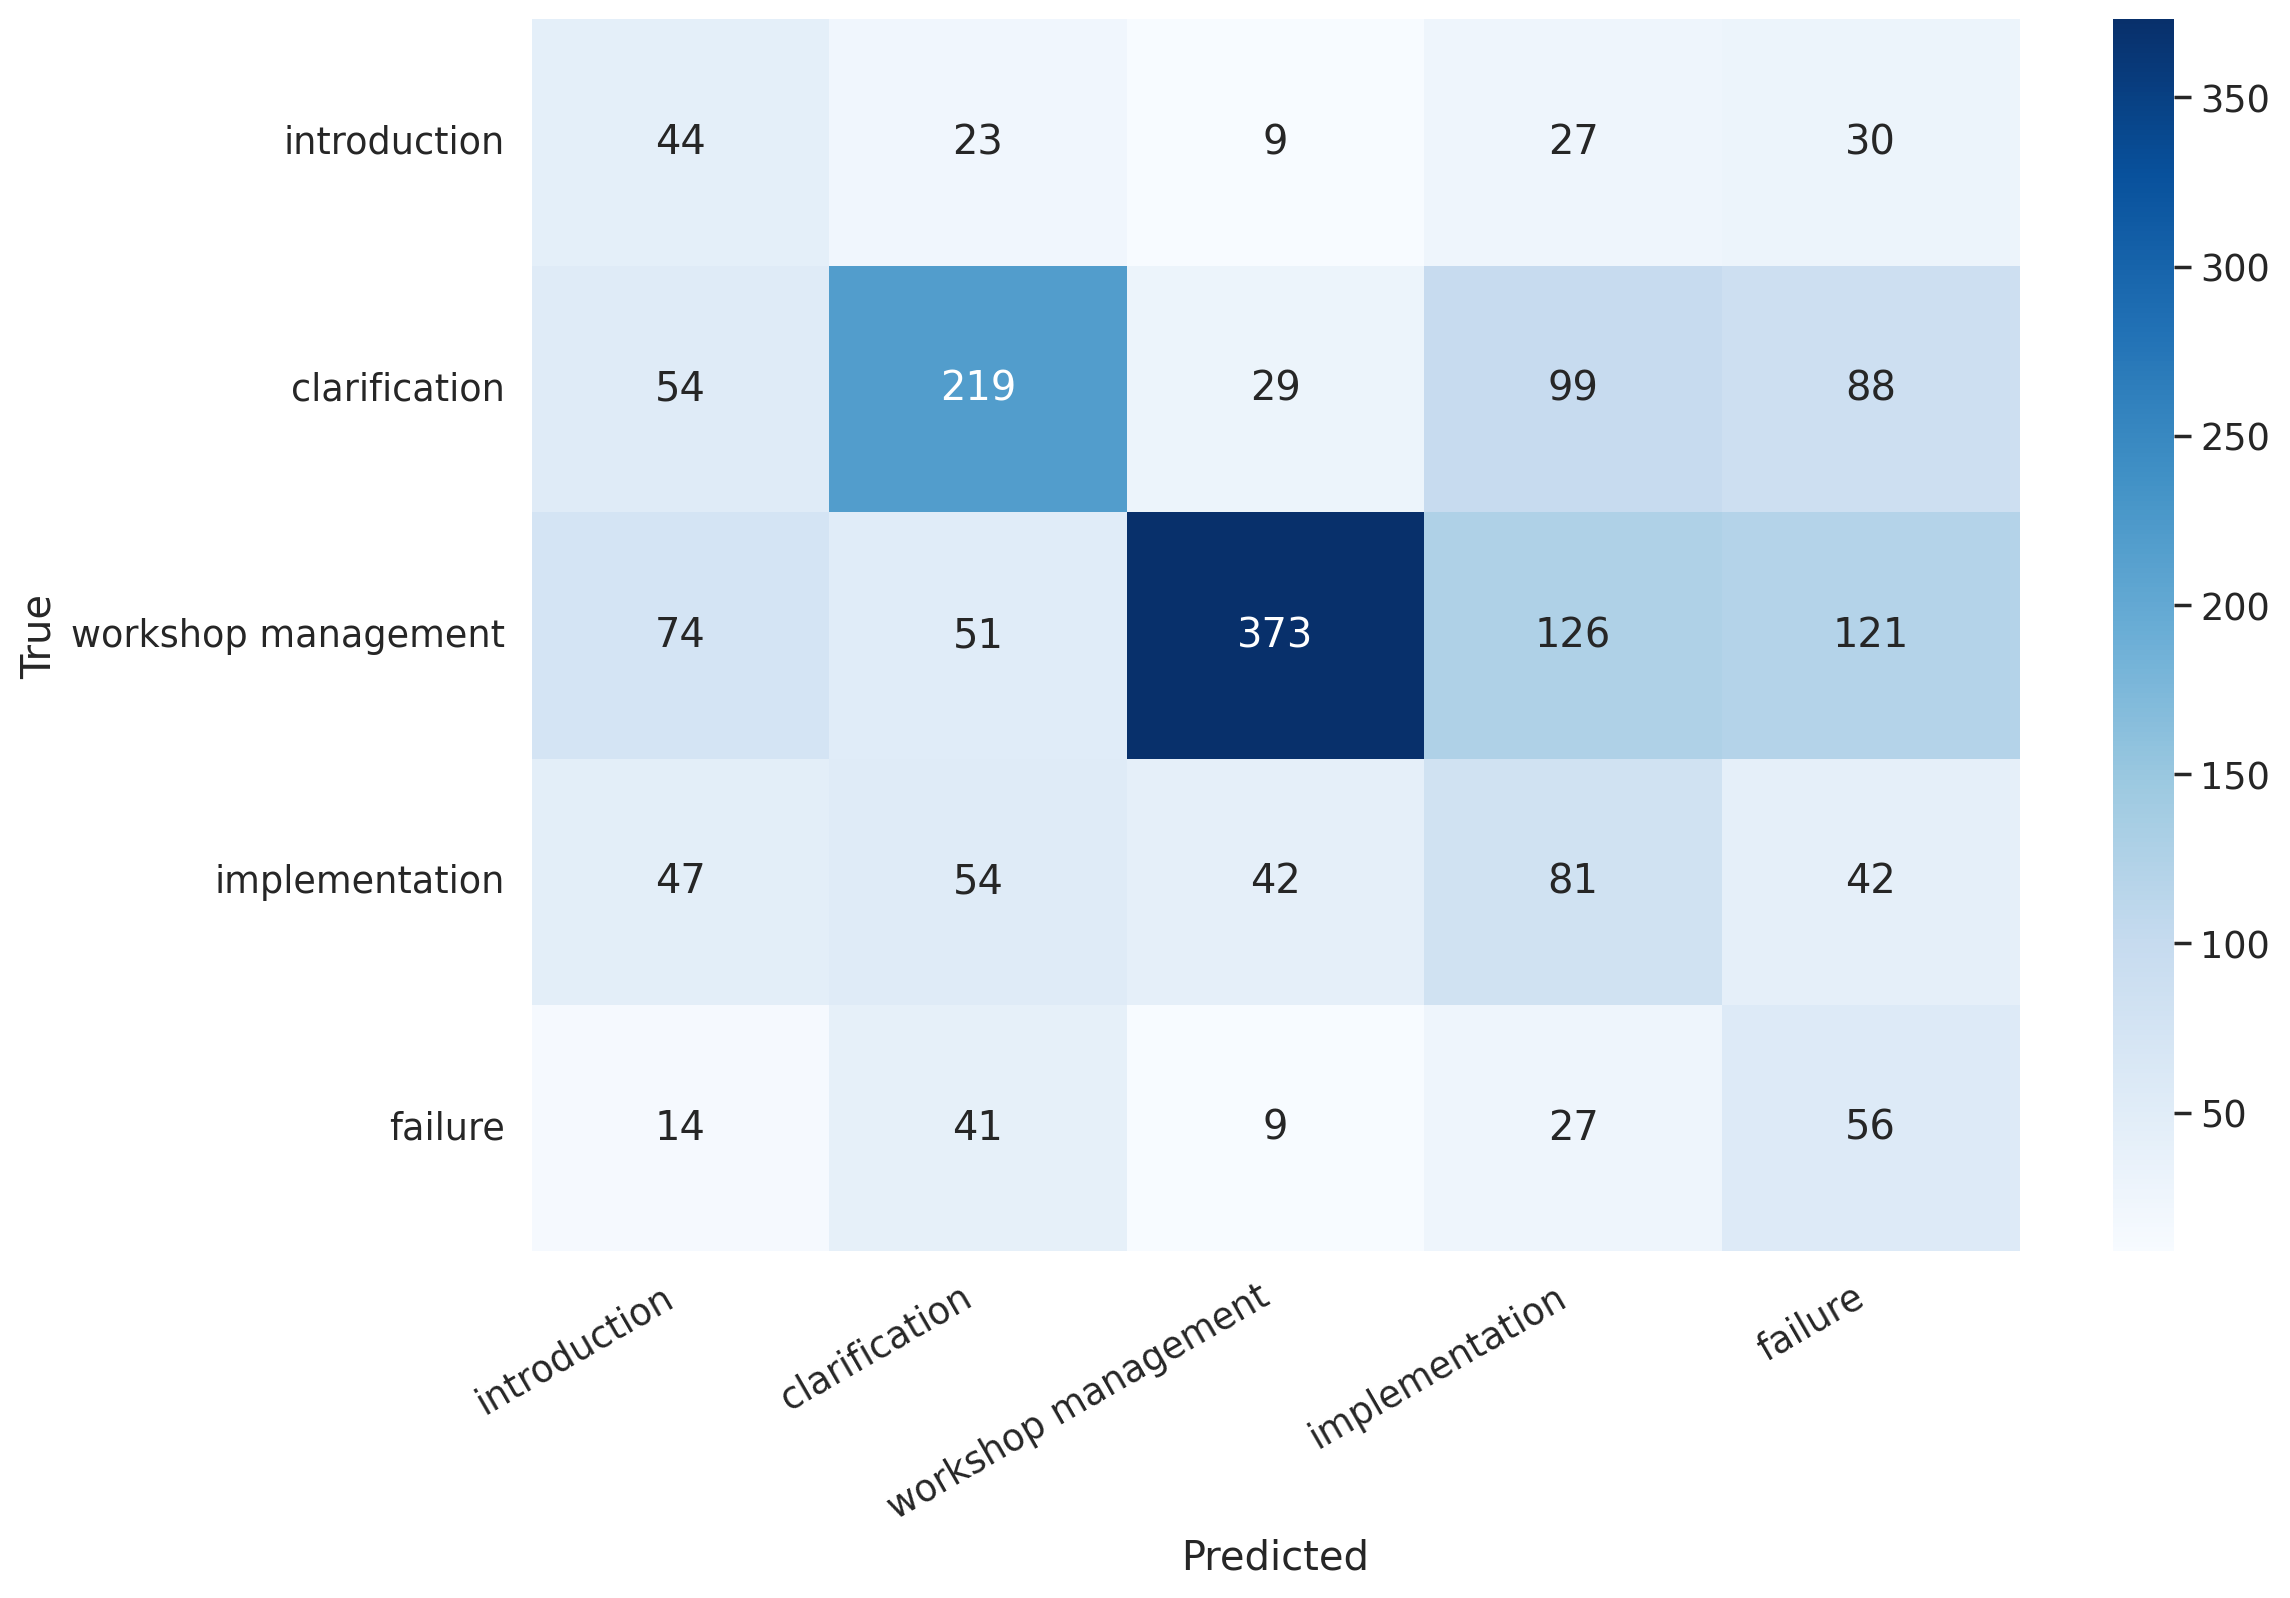

In [30]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [31]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.19      0.33      0.24       133
      clarification       0.56      0.45      0.50       489
workshop management       0.81      0.50      0.62       745
     implementation       0.23      0.30      0.26       266
            failure       0.17      0.38      0.23       147

           accuracy                           0.43      1780
          macro avg       0.39      0.39      0.37      1780
       weighted avg       0.55      0.43      0.47      1780



# Participant

In [32]:
info_len=len(list(df_r.query('label=="introduction"').index))
des_len=len(list(df_r.query('label=="clarification"').index))
fa1_len=len(list(df_r.query('label=="workshop management"').index))
fa2_len=len(list(df_r.query('label=="implementation"').index))
per_len=len(list(df_r.query('label=="failure"').index))

In [33]:
import random
# Return a list of indices
info_idx=random.sample(list(df_p.query('label=="information"').index),10)
des_idx=random.sample(list(df_p.query('label=="design action"').index),10)
fa1_idx=random.sample(list(df_p.query('label=="failure action"').index),10)
fa2_idx=random.sample(list(df_p.query('label=="failure reasoning"').index),10)
per_idx=random.sample(list(df_p.query('label=="perception"').index),10)

# Use indices to select data
train_p = df_p.loc[info_idx + des_idx + fa1_idx+ fa2_idx + per_idx]
index_list=info_idx + des_idx + fa1_idx+ fa2_idx + per_idx

In [34]:
test_p=df_p.drop(index=(index_list))
valid_p, test_p = train_test_split(test_p, test_size=0.8)

In [35]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [37]:
# define parameters
EPOCHS = 20

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'huggingface.co'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkp

In [38]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.8816770017147064 accuracy 0.1


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6359089250149934 accuracy 0.92

Epoch 2/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.5908180475234985 accuracy 0.28


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.646362040353858 accuracy 0.96

Epoch 3/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.4490936994552612 accuracy 0.28


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.672259351481562 accuracy 1.26

Epoch 4/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.2871626615524292 accuracy 0.38


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.7076662416043489 accuracy 1.24

Epoch 5/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 1.1524480879306793 accuracy 0.36


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6624389109404192 accuracy 1.24

Epoch 6/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.9937425702810287 accuracy 0.6


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.7238101129946501 accuracy 1.42

Epoch 7/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.8354688882827759 accuracy 0.72


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.9525367488031802 accuracy 1.48

Epoch 8/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.6580140292644501 accuracy 0.8


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.6539208681687065 accuracy 2.16

Epoch 9/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.46780343540012836 accuracy 0.9400000000000001


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.8619476038476694 accuracy 1.78

Epoch 10/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.3203318100422621 accuracy 0.98


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.151859620343084 accuracy 1.7

Epoch 11/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.22057253494858742 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.8913289930509485 accuracy 1.86

Epoch 12/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.1376895047724247 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 1.9139155667761099 accuracy 2.1

Epoch 13/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.10012518567964435 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.0935322046279907 accuracy 1.8

Epoch 14/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.07070902443956584 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.1432686940483423 accuracy 1.98

Epoch 15/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.049437797628343105 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.167627855487492 accuracy 2.08

Epoch 16/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.03992570214904845 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.223394697127135 accuracy 2.04

Epoch 17/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.03053747967351228 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.2777301461800286 accuracy 2.06

Epoch 18/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.029327536933124065 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.290881711503734 accuracy 2.04

Epoch 19/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.024675885448232293 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.300242175226626 accuracy 2.06

Epoch 20/20
----------


  0%|          | 0/4 [00:00<?, ?it/s]

Train loss 0.02289978484623134 accuracy 1.0


  0%|          | 0/23 [00:00<?, ?it/s]

Val loss 2.310152421826902 accuracy 2.1



In [39]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [40]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.32737043398488347

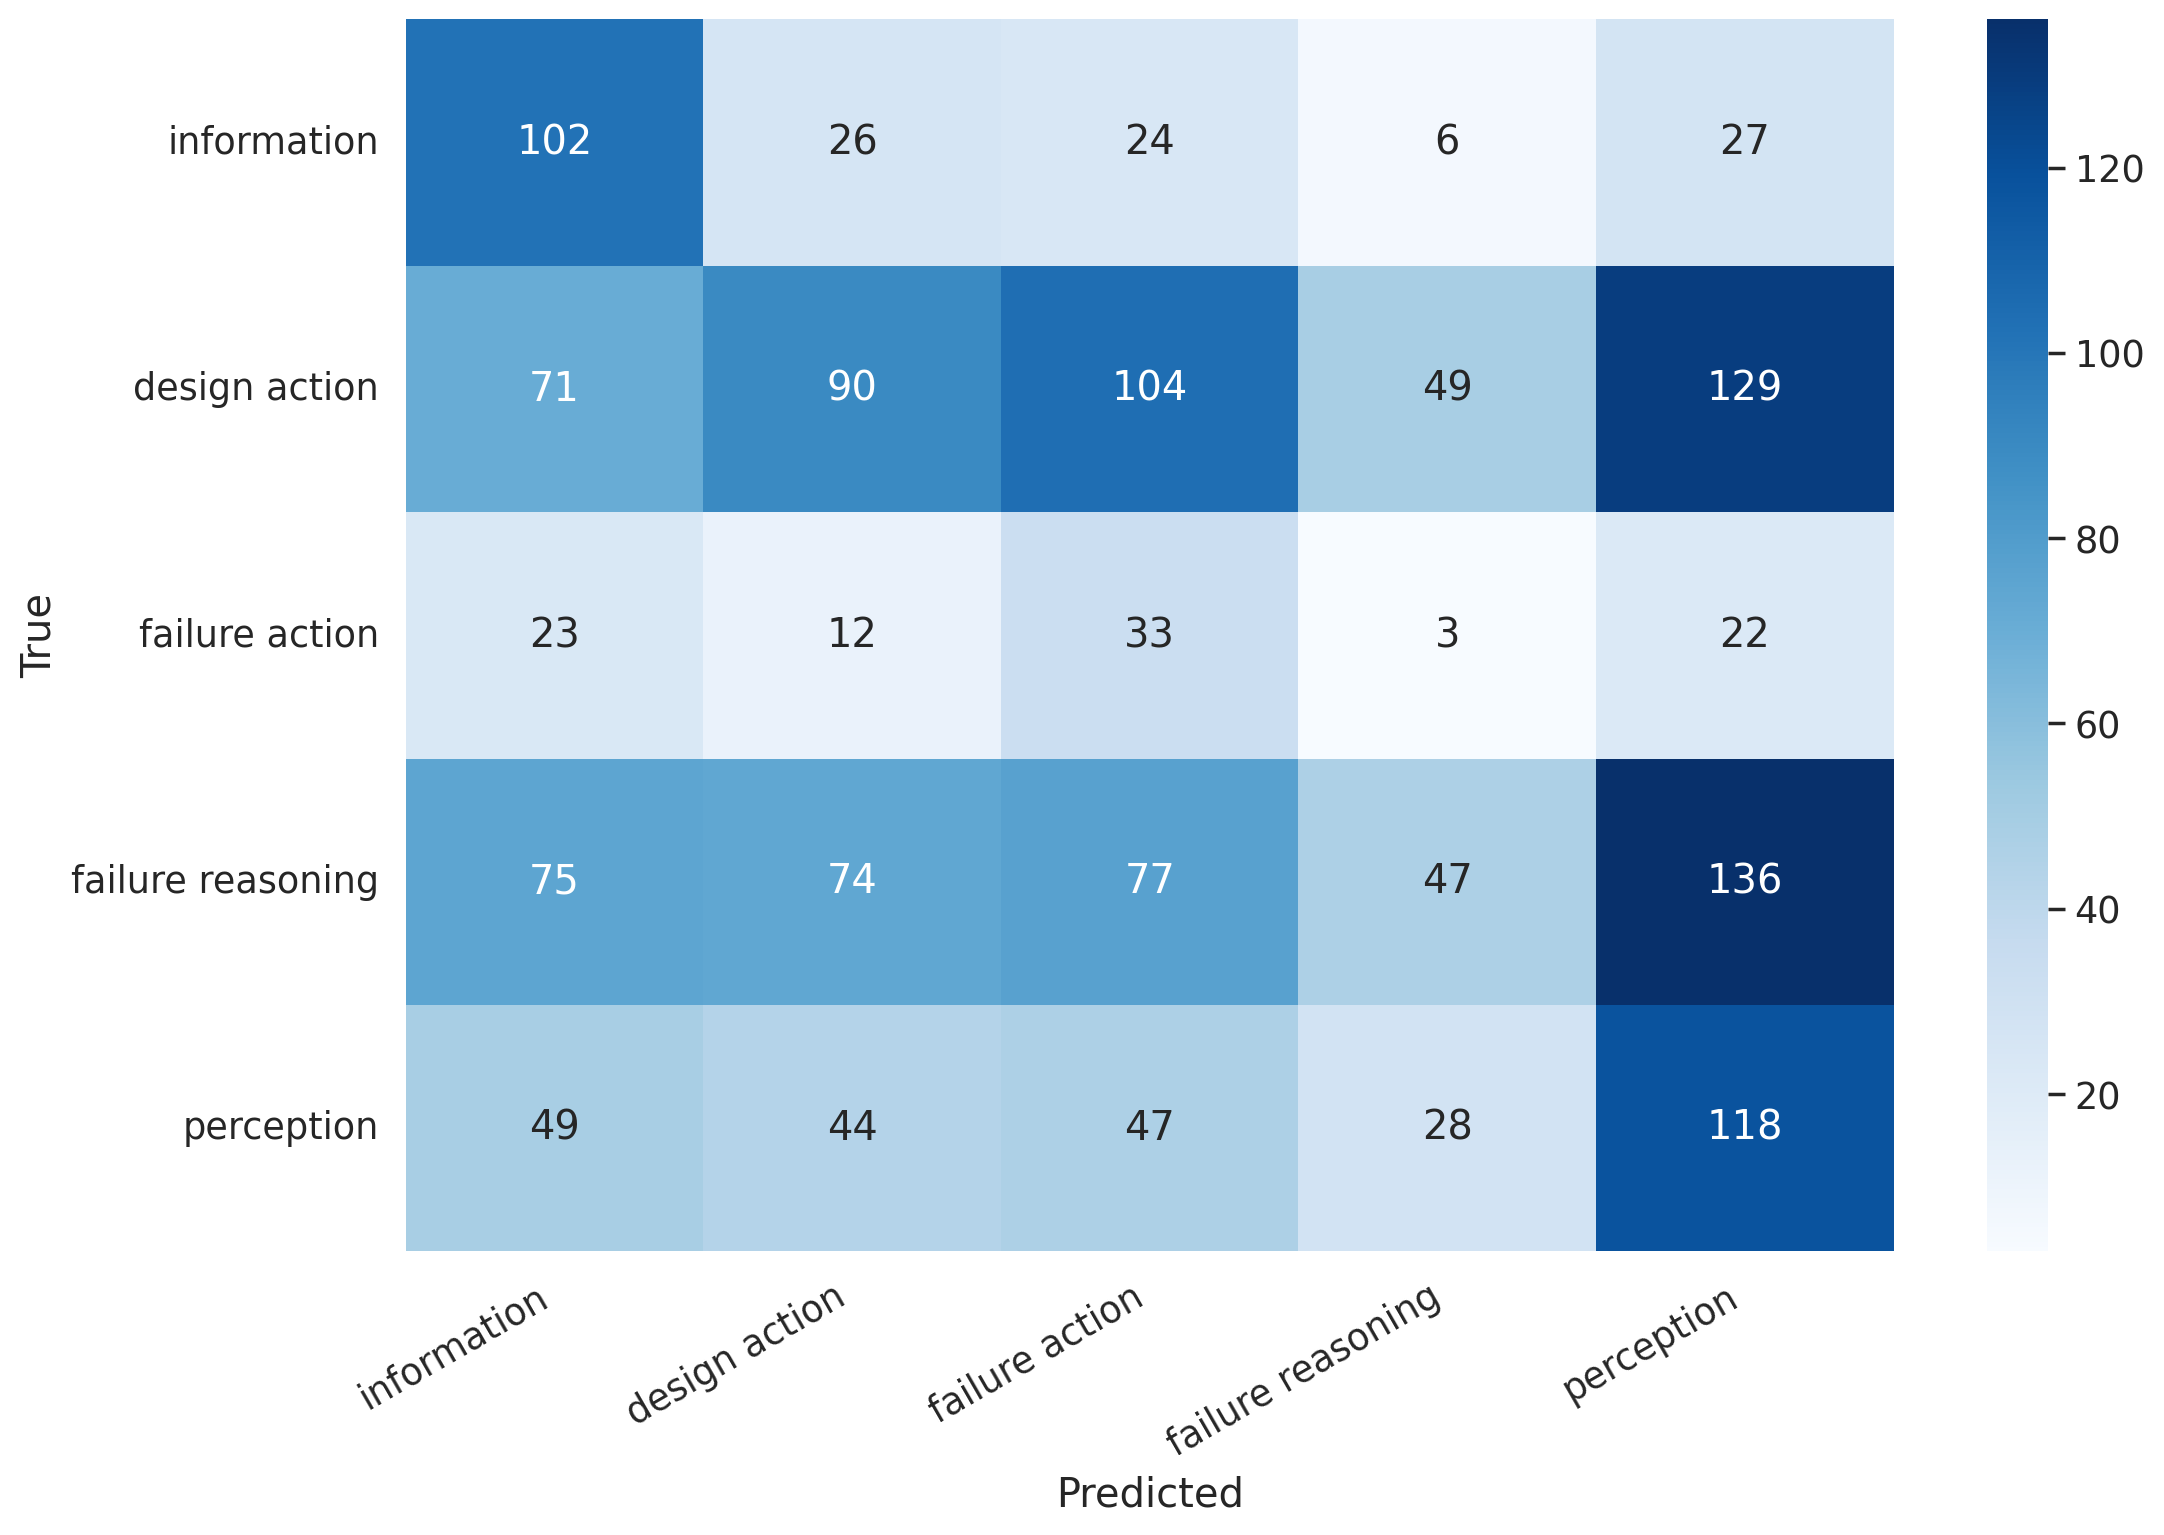

In [43]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [42]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.32      0.55      0.40       185
    design action       0.37      0.20      0.26       443
   failure action       0.12      0.35      0.17        93
failure reasoning       0.35      0.11      0.17       409
       perception       0.27      0.41      0.33       286

         accuracy                           0.28      1416
        macro avg       0.29      0.33      0.27      1416
     weighted avg       0.32      0.28      0.26      1416

